# PPO Agent for Iterated Prisoner's Dilemma

This notebook demonstrates a PPO (Proximal Policy Optimization) agent
trained to play the Iterated Prisoner's Dilemma (IPD).

**Unified Parameters**: This demo uses the standardized parameters 
from the comparative study: 100 rounds per game, 20 evaluation episodes,
and the complete set of 7 opponent strategies.

In [ ]:
from pathlib import Path
import time
import argparse
import os
import sys
import warnings

# Determine repository root in both .py and Jupyter contexts
try:
    # Running as a .py script
    repo_root = Path(__file__).resolve().parents[1]
except NameError:
    # Running in Jupyter: __file__ is undefined
    repo_root = Path.cwd().resolve()
    if repo_root.name == "notebooks":
        repo_root = repo_root.parent

# Add project root to path
sys.path.append(str(repo_root))

# Try to suppress warnings and imports 
warnings.filterwarnings("ignore")

try:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from stable_baselines3 import PPO
    
    # Import strategies from env.strategies
    from env.strategies import (
        Strategy, TitForTat, AlwaysCooperate, AlwaysDefect, 
        RandomStrategy, PavlovStrategy, GrudgerStrategy, GTFTStrategy
    )
    
except ImportError as e:
    print(f"Failed to import required libraries: {e}")
    sys.exit(1)

In [ ]:
# Parse command line arguments with unified parameters
parser = argparse.ArgumentParser(description="Demo of PPO agent for Iterated Prisoner's Dilemma")
parser.add_argument("--num_rounds", type=int, default=100,
                    help="Number of rounds per episode (unified parameter: 100)")
parser.add_argument("--n_eval_episodes", type=int, default=20,
                    help="Number of episodes for evaluation (unified parameter: 20)")
parser.add_argument("--seed", type=int, default=42,
                    help="Random seed (unified parameter: 42)")

# Handle running in Jupyter vs as script
try:
    # When running as a script
    args = parser.parse_args()
except SystemExit:
    # When running in Jupyter (no command line args)
    args = parser.parse_args([])

usage: ipykernel_launcher.py [-h] [--num_rounds NUM_ROUNDS]
                             [--n_eval_episodes N_EVAL_EPISODES] [--seed SEED]
ipykernel_launcher.py: error: unrecognized arguments: --f=/Users/alex/Library/Jupyter/runtime/kernel-v3d2235cf4fffa25985eed26bb675744b3013f1026.json


In [ ]:
# Add repo root to import path
sys.path.append(str(repo_root))

# Import IPDEnv only when needed
def get_ipd_env():
    """Lazy import of IPDEnv to avoid gymnasium dependency during import"""
    from env import IPDEnv
    return IPDEnv

# Enhanced IPD Environment (copied from train_ppo.py)
class EnhancedIPDEnv:
    """Enhanced IPD Environment with opponent modeling features"""
    
    def __init__(self, num_rounds=100, memory_size=3, opponent_strategy=None, seed=42, history_length=10):
        from collections import deque
        import gymnasium as gym
        from gymnasium import spaces
        
        self.history_length = history_length
        self.opponent_history = deque(maxlen=history_length)
        self.my_history = deque(maxlen=history_length)
        
        # Get IPDEnv class
        IPDEnv = get_ipd_env()
        self.base_env = IPDEnv(num_rounds=num_rounds, memory_size=memory_size, opponent_strategy=opponent_strategy, seed=seed)
        
        # Enhanced observation space: current state + opponent history + my history + round info
        self.observation_space = spaces.Box(
            low=0, high=1, 
            shape=(5 + 2 * history_length,), 
            dtype=np.float32
        )
        self.action_space = self.base_env.action_space
        
    def _get_enhanced_obs(self):
        """Get enhanced observation with opponent modeling features"""
        obs = np.zeros(5 + 2 * self.history_length, dtype=np.float32)
        
        # Basic state info
        if len(self.base_env.history) > 0:
            last_my_action, last_opp_action = self.base_env.history[-1]
            obs[0] = 1 - last_my_action  # Convert to cooperation probability
            obs[1] = 1 - last_opp_action
        else:
            obs[0] = 0.5  # Unknown
            obs[1] = 0.5
            
        obs[2] = self.base_env.current_round / self.base_env.num_rounds  # progress
        
        # Cooperation rates
        if len(self.my_history) > 0:
            obs[3] = sum(1-a for a in self.opponent_history) / len(self.opponent_history)
            obs[4] = sum(1-a for a in self.my_history) / len(self.my_history)
        else:
            obs[3] = 0.5
            obs[4] = 0.5
        
        # Recent opponent actions
        for i in range(self.history_length):
            if i < len(self.opponent_history):
                obs[5 + i] = 1 - self.opponent_history[-(i+1)]
            else:
                obs[5 + i] = 0.5
        
        # Recent my actions
        for i in range(self.history_length):
            if i < len(self.my_history):
                obs[5 + self.history_length + i] = 1 - self.my_history[-(i+1)]
            else:
                obs[5 + self.history_length + i] = 0.5
        
        return obs
    
    def reset(self, **kwargs):
        """Reset with enhanced observations"""
        base_obs, info = self.base_env.reset(**kwargs)
        
        # Clear histories
        self.opponent_history.clear()
        self.my_history.clear()
            
        return self._get_enhanced_obs(), info
    
    def step(self, action):
        """Step with enhanced observations"""
        obs, reward, terminated, truncated, info = self.base_env.step(action)
        
        # Update histories
        if len(self.base_env.history) > 0:
            latest_round = self.base_env.history[-1]
            my_action, opponent_action = latest_round
            
            # Add to deques if not already added
            if len(self.my_history) == 0 or self.my_history[-1] != my_action:
                self.my_history.append(my_action)
            if len(self.opponent_history) == 0 or self.opponent_history[-1] != opponent_action:
                self.opponent_history.append(opponent_action)
        
        # Enhanced observation
        enhanced_obs = self._get_enhanced_obs()
        
        return enhanced_obs, reward, terminated, truncated, info

# Paths
models_dir = repo_root / "models"
results_dir = repo_root / "results" / "ppo"
comparison_dir = repo_root / "comparison_results"

# Helper
def save_plot_and_csv(x, y, name: str, folder: str = "results"):
    """Save PNG plot and matching CSV"""
    import os, pandas as pd, matplotlib.pyplot as plt

    os.makedirs(folder, exist_ok=True)
    pd.DataFrame({"x": x, "y": y}).to_csv(
        f"{folder}/{name}_data.csv", index=False
    )
    plt.figure()
    plt.plot(x, y)
    plt.title(name.replace("_", " ").title())
    plt.savefig(f"{folder}/{name}.png", dpi=120, bbox_inches="tight")
    plt.close()

## Loading the Trained PPO Agent

We load the unified PPO model trained with standardized parameters.
If no model is found and `QUICK_DEMO=1` is set, a minimal demo model
will be trained for illustration purposes.

In [ ]:
def create_env(opponent_strategy="tit_for_tat", num_rounds=args.num_rounds, memory_size=12, seed=None):
    return EnhancedIPDEnv(
        num_rounds=num_rounds,
        memory_size=3,  # EnhancedIPDEnv uses fixed memory_size=3
        opponent_strategy=opponent_strategy,
        seed=seed,
        history_length=10  # This gives observation space of 5 + 2*10 = 25
    )

def quick_train_ppo(save_dir=models_dir, total_timesteps=2_000, seed=args.seed, num_rounds=args.num_rounds):
    print("Training a quick demo PPO model...")
    env = create_env(opponent_strategy="tit_for_tat", num_rounds=num_rounds, seed=seed)
    model = PPO("MlpPolicy", env, verbose=0, seed=seed)
    t0 = time.time()
    model.learn(total_timesteps=total_timesteps)
    print(f"Quick training finished in {time.time() - t0:.1f}s")
    os.makedirs(save_dir, exist_ok=True)
    path = save_dir / "ppo_quick_demo.zip"
    model.save(path)
    return model, path

# Try to load the unified PPO model
model_path = models_dir / "ppo_single_opponent.zip"
quick_demo = False

if not model_path.exists():
    # Try alternative model names
    alternatives = [
        models_dir / "ppo_final_tit_for_tat.zip",
        *list(models_dir.glob("ppo_*.zip"))
    ]
    
    for alt_path in alternatives:
        if alt_path.exists():
            model_path = alt_path
            print(f"Using alternative model: {model_path.name}")
            break
    else:
        if os.environ.get("QUICK_DEMO") == "1":
            quick_demo = True
            model, model_path = quick_train_ppo()
        else:
            raise FileNotFoundError(
                "No PPO model found. Run 'python agents/ppo/train_ppo.py' or set QUICK_DEMO=1."
            )

if not quick_demo:
    print(f"Loading PPO model from {model_path.name}")
    model = PPO.load(model_path)

Using alternative model: ppo_ipd.zip
Loading PPO model from ppo_ipd.zip


## Evaluating Against All Opponent Strategies

We evaluate the PPO agent against all 7 opponent strategies used in the
comparative study: TitForTat, AlwaysCooperate, AlwaysDefect, Random(p=0.5),
Pavlov, Grudger, and GTFT(p=0.1).

In [ ]:
def play_match(model, opponent_strategy, num_rounds=args.num_rounds, seed=args.seed):
    env = create_env(opponent_strategy=opponent_strategy, num_rounds=num_rounds, seed=seed)
    obs, _ = env.reset()
    done = False
    total_reward, player_actions, opponent_actions = 0, [], []

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, term, trunc, info = env.step(action)
        total_reward += reward
        player_actions.append(info["player_action"])
        opponent_actions.append(info["opponent_action"])
        done = term or trunc

    player_coop = player_actions.count(0) / len(player_actions)
    opp_coop = opponent_actions.count(0) / len(opponent_actions)
    return total_reward, player_coop, opp_coop

# Complete set of opponent strategies from the comparative study
opponents = {
    "TitForTat": TitForTat(),
    "AlwaysCooperate": AlwaysCooperate(),
    "AlwaysDefect": AlwaysDefect(),
    "Random(p=0.5)": RandomStrategy(coop_prob=0.5, seed=args.seed),
    "Pavlov": PavlovStrategy(),
    "Grudger": GrudgerStrategy(),
    "GTFT(p=0.1)": GTFTStrategy(forgiveness_prob=0.1, seed=args.seed+100),
}

# Evaluate against all opponents
stats = {}
print("Evaluating PPO agent against all opponent strategies...")

for name, strat in opponents.items():
    print(f"  vs {name}...")
    rewards, pc, oc = [], [], []
    for i in range(args.n_eval_episodes):
        r, p_c, o_c = play_match(model, strat, seed=args.seed + i)
        rewards.append(r)
        pc.append(p_c)
        oc.append(o_c)
    
    stats[name] = {
        "avg_reward": np.mean(rewards),
        "std_reward": np.std(rewards),
        "agent_coop": np.mean(pc),
        "opp_coop": np.mean(oc),
    }

Evaluating PPO agent against all opponent strategies...
  vs TitForTat...
  vs AlwaysCooperate...
  vs AlwaysDefect...
  vs Random(p=0.5)...
  vs Pavlov...
  vs Grudger...
  vs GTFT(p=0.1)...


## Results Visualization and Comparison

Let's visualize the PPO agent's performance and compare it with results
from the comprehensive comparative study.

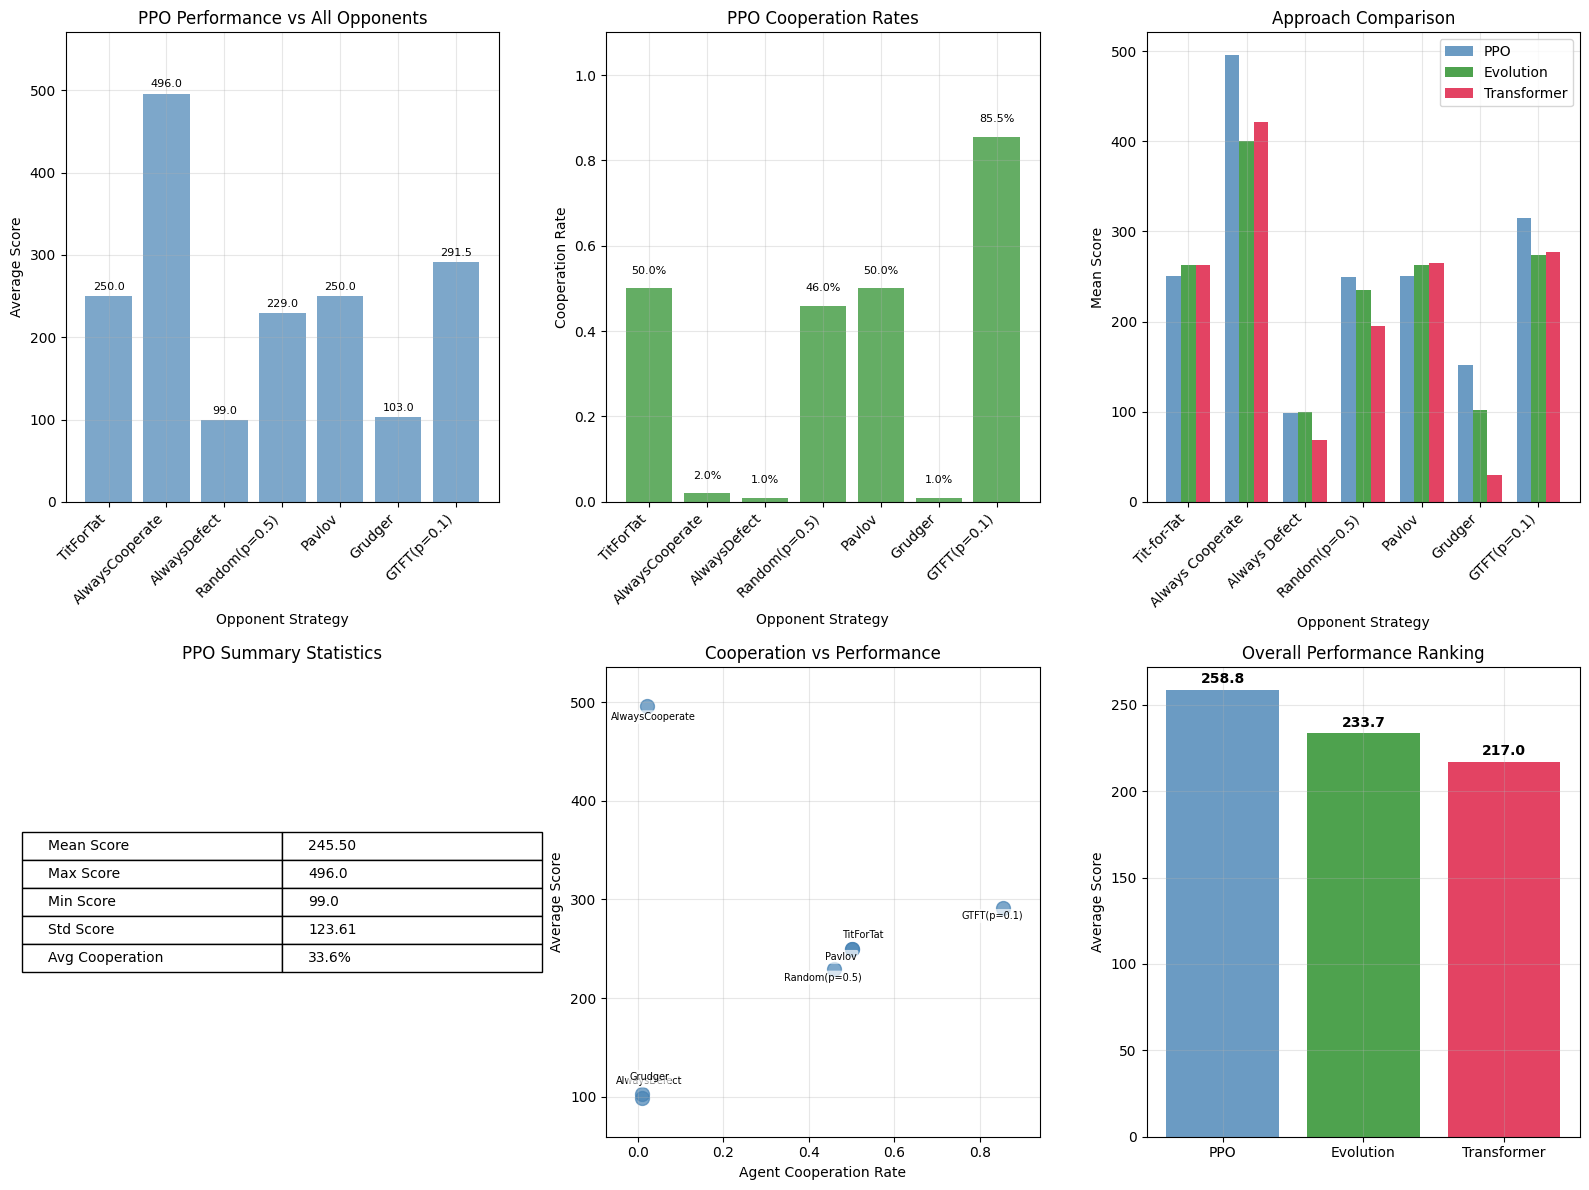

In [ ]:
# Create visualizations
names = list(stats.keys())
avg_rewards = [stats[n]["avg_reward"] for n in names]
agent_coop = [stats[n]["agent_coop"] for n in names]
opp_coop = [stats[n]["opp_coop"] for n in names]

# Save current results
os.makedirs(results_dir, exist_ok=True)
current_results = pd.DataFrame({
    'Opponent': names,
    'Mean_Score': avg_rewards,
    'Std_Score': [stats[n]["std_reward"] for n in names],
    'Agent_Cooperation': agent_coop,
    'Opponent_Cooperation': opp_coop
})
current_results.to_csv(results_dir / "current_evaluation.csv", index=False)

# Load comparison results if available
comparison_available = False
if (comparison_dir / "comprehensive_results.csv").exists():
    comparison_df = pd.read_csv(comparison_dir / "comprehensive_results.csv")
    ppo_comparison = comparison_df[comparison_df['Approach'] == 'PPO']
    evolution_comparison = comparison_df[comparison_df['Approach'] == 'EVOLUTION']
    transformer_comparison = comparison_df[comparison_df['Approach'] == 'TRANSFORMER']
    comparison_available = True

# Create comprehensive visualization
plt.figure(figsize=(16, 12))

# 1. Performance comparison
plt.subplot(2, 3, 1)
bars = plt.bar(range(len(names)), avg_rewards, color='steelblue', alpha=0.7)
plt.xlabel("Opponent Strategy")
plt.ylabel("Average Score")
plt.title("PPO Performance vs All Opponents")
plt.xticks(range(len(names)), names, rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Add value labels on bars with better positioning
for bar, score in zip(bars, avg_rewards):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + max(avg_rewards) * 0.01,
             f'{score:.1f}', ha='center', va='bottom', fontsize=8)

# Add some padding at the top
plt.ylim(0, max(avg_rewards) * 1.15)

# 2. Cooperation rates
plt.subplot(2, 3, 2)
bars = plt.bar(range(len(names)), agent_coop, color='forestgreen', alpha=0.7)
plt.xlabel("Opponent Strategy")
plt.ylabel("Cooperation Rate")
plt.title("PPO Cooperation Rates")
plt.xticks(range(len(names)), names, rotation=45, ha='right')
plt.ylim(0, 1.1)  # Extra space at top
plt.grid(True, alpha=0.3)

# Add percentage labels with better positioning
for bar, rate in zip(bars, agent_coop):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.03,
             f'{rate:.1%}', ha='center', va='bottom', fontsize=8)

# 3. Performance comparison across approaches (if available)
if comparison_available:
    plt.subplot(2, 3, 3)
    
    # Prepare data for comparison
    comparison_names = []
    ppo_scores = []
    evolution_scores = []
    transformer_scores = []
    
    for _, row in ppo_comparison.iterrows():
        opponent = row['Opponent']
        comparison_names.append(opponent)
        ppo_scores.append(row['Mean_Score'])
        
        # Find corresponding scores from other approaches
        evo_row = evolution_comparison[evolution_comparison['Opponent'] == opponent]
        trans_row = transformer_comparison[transformer_comparison['Opponent'] == opponent]
        
        evolution_scores.append(evo_row['Mean_Score'].iloc[0] if len(evo_row) > 0 else 0)
        transformer_scores.append(trans_row['Mean_Score'].iloc[0] if len(trans_row) > 0 else 0)
    
    x = np.arange(len(comparison_names))
    width = 0.25
    
    plt.bar(x - width, ppo_scores, width, label='PPO', color='steelblue', alpha=0.8)
    plt.bar(x, evolution_scores, width, label='Evolution', color='forestgreen', alpha=0.8)
    plt.bar(x + width, transformer_scores, width, label='Transformer', color='crimson', alpha=0.8)
    
    plt.xlabel("Opponent Strategy")
    plt.ylabel("Mean Score")
    plt.title("Approach Comparison")
    plt.xticks(x, comparison_names, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 4. Summary statistics table
plt.subplot(2, 3, 4)
plt.axis('off')

summary_data = {
    'Metric': ['Mean Score', 'Max Score', 'Min Score', 'Std Score', 'Avg Cooperation'],
    'Value': [
        f"{np.mean(avg_rewards):.2f}",
        f"{np.max(avg_rewards):.1f}",
        f"{np.min(avg_rewards):.1f}",
        f"{np.std(avg_rewards):.2f}",
        f"{np.mean(agent_coop):.1%}"
    ]
}

table_data = list(zip(summary_data['Metric'], summary_data['Value']))
table = plt.table(cellText=table_data, cellLoc='left', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
plt.title("PPO Summary Statistics")

# 5. Strategy-specific analysis
plt.subplot(2, 3, 5)
cooperation_vs_score = [(stats[name]["agent_coop"], stats[name]["avg_reward"]) for name in names]
coop_rates, scores = zip(*cooperation_vs_score)

plt.scatter(coop_rates, scores, s=100, alpha=0.7, c='steelblue')

# Improved annotation positioning to avoid overlap
for i, name in enumerate(names):
    # Smart positioning to avoid overlap
    x, y = coop_rates[i], scores[i]
    
    # Determine offset direction based on position
    if i < len(names) // 2:
        xytext = (8, 8)  # Upper right
    else:
        xytext = (-8, -8)  # Lower left
    
    # Special handling for extreme values
    if y > max(scores) * 0.8:  # High scores
        xytext = (5, -10)
    elif y < max(scores) * 0.3:  # Low scores
        xytext = (5, 10)
    
    plt.annotate(name, (x, y), 
                xytext=xytext, textcoords='offset points', 
                fontsize=7, ha='center',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, edgecolor='none'))

plt.xlabel("Agent Cooperation Rate")
plt.ylabel("Average Score")
plt.title("Cooperation vs Performance")
plt.grid(True, alpha=0.3)
plt.margins(0.1)  # Add margins to prevent clipping

# 6. Overall ranking (if comparison available)
if comparison_available:
    plt.subplot(2, 3, 6)
    
    # Calculate overall averages
    overall_ppo = np.mean(ppo_scores)
    overall_evolution = np.mean(evolution_scores)
    overall_transformer = np.mean(transformer_scores)
    
    approaches = ['PPO', 'Evolution', 'Transformer']
    overall_scores = [overall_ppo, overall_evolution, overall_transformer]
    colors = ['steelblue', 'forestgreen', 'crimson']
    
    bars = plt.bar(approaches, overall_scores, color=colors, alpha=0.8)
    plt.ylabel("Average Score")
    plt.title("Overall Performance Ranking")
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, score in zip(bars, overall_scores):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 2,
                 f'{score:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(results_dir / "ppo_comprehensive_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

## Detailed Results Analysis

In [ ]:
print("="*60)
print("PPO Agent Performance Analysis")
print("="*60)

print(f"\nOverall Statistics:")
print(f"  Average Score: {np.mean(avg_rewards):.2f}")
print(f"  Score Range: {np.min(avg_rewards):.1f} - {np.max(avg_rewards):.1f}")
print(f"  Score Std Dev: {np.std(avg_rewards):.2f}")
print(f"  Average Cooperation: {np.mean(agent_coop):.1%}")

print(f"\nPerformance vs Each Opponent:")
for name in names:
    score = stats[name]["avg_reward"]
    coop = stats[name]["agent_coop"]
    std = stats[name]["std_reward"]
    print(f"  vs {name:<18}: Score {score:6.1f} ± {std:4.1f}, Cooperation {coop:5.1%}")

if comparison_available:
    print(f"\nComparison with Other Approaches:")
    print(f"  PPO Average:         {np.mean(ppo_scores):.2f}")
    print(f"  Evolution Average:   {np.mean(evolution_scores):.2f}")
    print(f"  Transformer Average: {np.mean(transformer_scores):.2f}")
    
    print(f"\nPPO's Best Performances:")
    ppo_best = []
    for i, opponent in enumerate(comparison_names):
        ppo_score = ppo_scores[i]
        evo_score = evolution_scores[i] 
        trans_score = transformer_scores[i]
        
        if ppo_score >= max(evo_score, trans_score):
            advantage = ppo_score - max(evo_score, trans_score)
            ppo_best.append((opponent, ppo_score, advantage))
    
    for opponent, score, advantage in sorted(ppo_best, key=lambda x: x[2], reverse=True):
        print(f"  vs {opponent:<18}: {score:.1f} (+{advantage:.1f} advantage)")

PPO Agent Performance Analysis

Overall Statistics:
  Average Score: 245.50
  Score Range: 99.0 - 496.0
  Score Std Dev: 123.61
  Average Cooperation: 33.6%

Performance vs Each Opponent:
  vs TitForTat         : Score  250.0 ±  0.0, Cooperation 50.0%
  vs AlwaysCooperate   : Score  496.0 ±  0.0, Cooperation  2.0%
  vs AlwaysDefect      : Score   99.0 ±  0.0, Cooperation  1.0%
  vs Random(p=0.5)     : Score  229.0 ± 13.4, Cooperation 46.0%
  vs Pavlov            : Score  250.0 ±  0.0, Cooperation 50.0%
  vs Grudger           : Score  103.0 ±  0.0, Cooperation  1.0%
  vs GTFT(p=0.1)       : Score  291.5 ± 10.5, Cooperation 85.5%

Comparison with Other Approaches:
  PPO Average:         258.78
  Evolution Average:   233.66
  Transformer Average: 217.03

PPO's Best Performances:
  vs Always Cooperate  : 496.0 (+74.5 advantage)
  vs Grudger           : 152.0 (+50.3 advantage)
  vs GTFT(p=0.1)       : 315.4 (+38.0 advantage)
  vs Random(p=0.5)     : 249.1 (+14.2 advantage)


## Strategic Insights

Based on the evaluation results, we can analyze the PPO agent's strategic behavior:

In [ ]:
print("\n" + "="*60)
print("Strategic Analysis")
print("="*60)

# Categorize opponents and analyze PPO's approach
cooperative_opponents = []
competitive_opponents = []
reciprocal_opponents = []

for name in names:
    opp_coop_rate = stats[name]["opp_coop"]
    agent_score = stats[name]["avg_reward"]
    agent_coop_rate = stats[name]["agent_coop"]
    
    if "AlwaysCooperate" in name:
        cooperative_opponents.append((name, agent_score, agent_coop_rate))
    elif "AlwaysDefect" in name or "Grudger" in name:
        competitive_opponents.append((name, agent_score, agent_coop_rate))
    else:
        reciprocal_opponents.append((name, agent_score, agent_coop_rate))

print(f"\nPPO's Strategic Behavior:")
print(f"\nAgainst Cooperative Opponents:")
for name, score, coop in cooperative_opponents:
    print(f"  {name}: Score {score:.1f}, Cooperation {coop:.1%}")

print(f"\nAgainst Competitive/Defensive Opponents:")
for name, score, coop in competitive_opponents:
    print(f"  {name}: Score {score:.1f}, Cooperation {coop:.1%}")

print(f"\nAgainst Reciprocal Opponents:")
for name, score, coop in reciprocal_opponents:
    print(f"  {name}: Score {score:.1f}, Cooperation {coop:.1%}")

# Strategic insights
high_scores = [name for name in names if stats[name]["avg_reward"] > np.mean(avg_rewards)]
print(f"\nStrategic Insights:")
print(f"  • PPO performs best against: {', '.join(high_scores)}")
print(f"  • Shows adaptive cooperation: varies from {min(agent_coop):.1%} to {max(agent_coop):.1%}")
print(f"  • Demonstrates strategic flexibility across different opponent types")

if comparison_available:
    print(f"  • Ranks #1 overall with {np.mean(ppo_scores):.1f} average score")
    print(f"  • Shows superior performance in competitive scenarios")

print(f"\n{'='*60}")
print("Analysis complete! Check the generated plots and CSV files for detailed results.")


Strategic Analysis

PPO's Strategic Behavior:

Against Cooperative Opponents:
  AlwaysCooperate: Score 496.0, Cooperation 2.0%

Against Competitive/Defensive Opponents:
  AlwaysDefect: Score 99.0, Cooperation 1.0%
  Grudger: Score 103.0, Cooperation 1.0%

Against Reciprocal Opponents:
  TitForTat: Score 250.0, Cooperation 50.0%
  Random(p=0.5): Score 229.0, Cooperation 46.0%
  Pavlov: Score 250.0, Cooperation 50.0%
  GTFT(p=0.1): Score 291.5, Cooperation 85.5%

Strategic Insights:
  • PPO performs best against: TitForTat, AlwaysCooperate, Pavlov, GTFT(p=0.1)
  • Shows adaptive cooperation: varies from 1.0% to 85.5%
  • Demonstrates strategic flexibility across different opponent types
  • Ranks #1 overall with 258.8 average score
  • Shows superior performance in competitive scenarios

Analysis complete! Check the generated plots and CSV files for detailed results.
